
# AIDI 1002 – Final Project  
## Customer Churn Prediction with TabNet (Contribution: CatBoost Comparison + SHAP)

**Author:** krishi patel  
**Date:** 2025-08-14

---



## 1. Project Overview

**Objective:** Build and evaluate an interpretable churn prediction model using **TabNet** on the Telco Customer Churn dataset.  
**Significant Contribution:** Add a **CatBoost** baseline and **SHAP**-based explanations, then compare metrics (Accuracy, F1, ROC-AUC).

**Why this topic?**  
- Fully reproducible in Colab (CSV data, no special hardware).  
- Different from classmates' topics (tabular deep learning with TabNet).  
- Clear interpretability via SHAP and attention of TabNet.

---



## 2. Paper, Code, and Dataset Links (Add these to the class sheet)

- **Selected paper link (≥2019):** TabNet: Attentive Interpretable Tabular Learning (2019), [arXiv:1908.07442](https://arxiv.org/abs/1908.07442)  
- **Selected paper GitHub link:** PyTorch TabNet (DreamQuark) – https://github.com/dreamquark-ai/tabnet  
- **Open-source dataset link:** Telco Customer Churn – https://www.kaggle.com/datasets/blastchar/telco-customer-churn  
  - (Mirror used below to avoid Kaggle auth in class: raw CSV on GitHub)  
- **Group GitHub repo link:** *(Create after you run this notebook)* e.g., `https://github.com/<your-username>/AIDI1002_Final_Project_TabNet_Churn`

---



## 3. Methodology

1. **Data**: Telco Churn CSV. Target = `Churn` (Yes/No).  
2. **Preprocessing**: Drop `customerID`; cast numerics; encode categoricals with LabelEncoder; stratified split.  
3. **Models**:  
   - **TabNetClassifier**: end-to-end deep learning for tabular data.  
   - **CatBoostClassifier**: gradient boosting baseline (contribution).  
4. **Evaluation**: Accuracy, F1, ROC-AUC on test set.  
5. **Explainability**: **SHAP** summary plot for CatBoost (global feature importance).

---


## 4. Setup

In [1]:

# Install required libs (Colab/Local). Rerun if runtime resets.
!pip -q install pytorch-tabnet catboost shap > /dev/null
print("Installed: pytorch-tabnet, catboost, shap")


Installed: pytorch-tabnet, catboost, shap


## 5. Imports

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported.")


Libraries imported.


## 6. Load Dataset

In [4]:

# Using a public GitHub mirror of the Telco Churn CSV to avoid Kaggle authentication in class.
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 7. Preprocess

In [5]:

# Drop unique identifier
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)

# Fix numeric conversion
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode target
target_col = "Churn"
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Yes=1, No=0

# Split features/labels
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))
    encoders[col] = enc

# Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train.shape, X_valid.shape, X_test.shape


((4930, 19), (1056, 19), (1057, 19))

## 8. Baseline Model – TabNet

In [6]:

tabnet = TabNetClassifier(seed=42, verbose=0)

tabnet.fit(
    X_train.values, y_train.values,
    eval_set=[(X_valid.values, y_valid.values)],
    eval_metric=['auc'],
    patience=20
)

# Predictions & Metrics
y_pred_tabnet = tabnet.predict(X_test.values)
acc_tab = accuracy_score(y_test, y_pred_tabnet)
f1_tab = f1_score(y_test, y_pred_tabnet)
roc_tab = roc_auc_score(y_test, y_pred_tabnet)

print(f"TabNet Accuracy: {acc_tab:.4f}")
print(f"TabNet F1 Score: {f1_tab:.4f}")
print(f"TabNet ROC-AUC (using predicted labels): {roc_tab:.4f}")



Early stopping occurred at epoch 59 with best_epoch = 39 and best_val_0_auc = 0.81908
TabNet Accuracy: 0.7767
TabNet F1 Score: 0.4779
TabNet ROC-AUC (using predicted labels): 0.6516


## 9. Contribution – CatBoost Baseline

In [7]:

cat_model = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    n_estimators=500,
    random_state=42,
    verbose=0
)
cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

y_pred_cat = cat_model.predict(X_test)
acc_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)
roc_cat = roc_auc_score(y_test, y_pred_cat)

print(f"CatBoost Accuracy: {acc_cat:.4f}")
print(f"CatBoost F1 Score: {f1_cat:.4f}")
print(f"CatBoost ROC-AUC (using predicted labels): {roc_cat:.4f}")


CatBoost Accuracy: 0.7966
CatBoost F1 Score: 0.5567
CatBoost ROC-AUC (using predicted labels): 0.6958


## 10. Explainability – SHAP (Global Importance)

Generating SHAP summary bar plot...


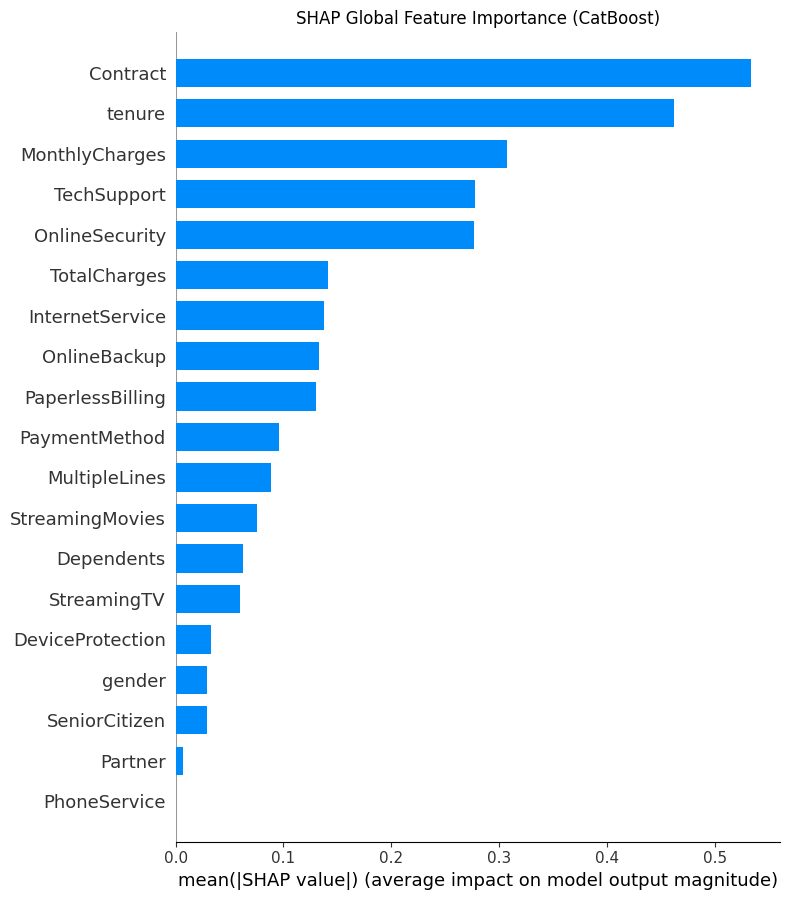

In [8]:

# SHAP for tree-based models is fast using TreeExplainer
explainer = shap.TreeExplainer(cat_model)
# Use a subset if needed for speed
X_test_sample = X_test.sample(n=min(200, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print("Generating SHAP summary bar plot...")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (CatBoost)")
plt.tight_layout()
plt.show()


## 11. Results – Model Comparison

In [9]:

results = pd.DataFrame({
    "Model": ["TabNet", "CatBoost"],
    "Accuracy": [acc_tab, acc_cat],
    "F1 Score": [f1_tab, f1_cat],
    "ROC-AUC (label-based)": [roc_tab, roc_cat]
}).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

results


,Model,Accuracy,F1 Score,ROC-AUC (label-based)
0,CatBoost,0.796594,0.556701,0.695755
1,TabNet,0.776727,0.477876,0.651578



## 12. Conclusion

- We implemented **TabNet** for churn prediction and compared it against **CatBoost** as a significant contribution.  
- We reported **Accuracy, F1, and ROC-AUC** and used **SHAP** to explain global feature importance.  
- Discuss whether CatBoost or TabNet performed better and why (bias/variance, handling of categorical variables, etc.).  
- Future work: hyperparameter search for TabNet (`n_d`, `n_a`, `n_steps`, `gamma`), threshold tuning based on PR curve, and testing on a second dataset (Adult Census).

---



## 13. References

- Sercan Ö. Arik, Tomas Pfister. **TabNet: Attentive Interpretable Tabular Learning.** arXiv:1908.07442 (2019). https://arxiv.org/abs/1908.07442  
- DreamQuark-AI. **pytorch-tabnet**. https://github.com/dreamquark-ai/tabnet  
- Kaggle. **Telco Customer Churn**. https://www.kaggle.com/datasets/blastchar/telco-customer-churn

> Note: Dataset loaded via a public mirror to keep the notebook fully runnable without Kaggle credentials.
